# GISready region plot

Date: 20 June, 2024

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

### BRAN2020 is on the order of 50TB of float data over nearly 9000 `netcdf` file assests in total.

#### required packages

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from dask.distributed import Client, LocalCluster
import dask
import datetime
import zarr

import gc
import sys
import subprocess
from tabulate import tabulate
import os
import glob
import streamjoy
import pickle
import json

import intake
import configparser

import regionmask
import cartopy.crs as ccrs
import seaborn as sns
from scipy.interpolate import griddata

import gsw


In [2]:
# Append the directory of the module to sys.path - import functions
sys.path.append('/g/data/es60/users/thomas_moore/code/Climatology-generator-demo/src/')
import bran2020_demo_functions as my_tools
from bran2020_demo_functions import keep_only_selected_vars, load_rechunker_config, print_chunks, rechunk_each_st_ocean, remove_zarr_encoding, version_table, concatinate_st_ocean_zarrs

#### start a local Dask client

In [3]:
# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

cluster = LocalCluster(
    n_workers=28,          # Number of workers
    threads_per_worker=1#,
    #memory_limit='8GB' # Memory limit per each worker
)
client = Client(cluster)

# paths

In [4]:
GISready_results_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/'
final_results_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_final_results/'
intermediate_results_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_intermediate_results/'

# functions

In [5]:
def load_GISready_ds(GISready_results_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/',
                     core_var='temp',phase='la_nina'):
    ds = xr.open_mfdataset(GISready_results_path+phase+'/'+core_var+'/*.nc',concat_dim='month',combine='nested',parallel=True)
    return ds

# load data from GISready files

In [6]:
GIS_temp_ds = xr.merge([load_GISready_ds(phase='alltime'),load_GISready_ds(phase='el_nino'),load_GISready_ds(phase='la_nina'),load_GISready_ds(phase='neutral')])
GIS_salt_ds = xr.merge([load_GISready_ds(phase='alltime',core_var='salt'),load_GISready_ds(phase='el_nino',core_var='salt'),load_GISready_ds(phase='la_nina',core_var='salt'),load_GISready_ds(phase='neutral',core_var='salt')])
GIS_u_ds = xr.merge([load_GISready_ds(phase='alltime',core_var='u'),load_GISready_ds(phase='el_nino',core_var='u'),
                     load_GISready_ds(phase='la_nina',core_var='u'),load_GISready_ds(phase='neutral',core_var='u')])
GIS_mld_ds = xr.merge([load_GISready_ds(phase='alltime',core_var='mld'),load_GISready_ds(phase='el_nino',core_var='mld'),
                     load_GISready_ds(phase='la_nina',core_var='mld'),load_GISready_ds(phase='neutral',core_var='mld')])

# sanity checks

## "final"

In [ ]:
final_temp_ds = xr.open_mfdataset(final_results_path+'*temp*.nc',parallel=True)
final_u_ds = xr.open_mfdataset(final_results_path+'*_u_*.nc',parallel=True)
final_mld_ds = xr.open_mfdataset(final_results_path+'*mld*.nc',parallel=True)
final_eta_t_ds = xr.open_mfdataset(final_results_path+'*_eta_t_*.nc',parallel=True)

## intermediate

In [ ]:
# Create an empty dictionary
dynamic_ds = {}

# Define your var and phase lists
var_values = ['temp', 'salt','u','v','eta_t','mld']  # 
phase_values = ['alltime', 'neutral','la_nina','el_nino']  # 


# Iterate over all combinations of var and phase
for var_name in var_values:
    for phase_name in phase_values:
        # Generate the object name
        ds_name = f'{var_name}_{phase_name}_ds'
        
        # Store the value in the dictionary
        results_path = intermediate_results_path
        files = glob.glob(results_path+'*_'+var_name+'_*'+phase_name+'*.nc')
        sorted_files = sorted(files, key=os.path.getctime)
        #print('>>>>> '+var_name+'&'+phase_name+' <<<<<')
        #print(sorted_files)
        
        dynamic_ds[ds_name] = xr.open_mfdataset(files,parallel=True)  # replace with your actual value


In [ ]:
# Add the phase string to the name of all variables in each dataset
for ds_name, dataset in dynamic_ds.items():
    # Get the phase name from the dataset name
    phase_name = '_'.join(ds_name.split('_')[1:-1])
    if phase_name not in phase_values:
        phase_name = '_'.join(ds_name.split('_')[2:-1])
    if phase_name in phase_values:
        # Add the phase string to the name of all variables
        for var_name in dataset.data_vars:
            new_var_name = f'{var_name}_{phase_name}'
            dataset = dataset.rename({var_name: new_var_name})
        dynamic_ds[ds_name] = dataset
    else:
        print(f"No match found for phase name: {phase_name}")

In [ ]:
merged_datasets = {}
for var_name in var_values:
        # Get all datasets with the same var_name
        var_datasets = [dataset for ds_name, dataset in dynamic_ds.items() if var_name+'_' in ds_name]
        
        # Merge the datasets along the time dimension
        merged_dataset = xr.merge(var_datasets)
        
        # Store the merged dataset in the dictionary
        merged_datasets[var_name] = merged_dataset
intermediate_datasets = merged_datasets

## Does "final" = "intermediate" dataset

In [ ]:
%%time
xr.testing.assert_equal(final_mld_ds,intermediate_datasets['mld'])

In [ ]:
%%time
xr.testing.assert_equal(final_eta_t_ds,intermediate_datasets['eta_t'])

In [ ]:
%%time
xr.testing.assert_equal(final_u_ds.mean_u_alltime,intermediate_datasets['u'].mean_u_alltime)

## Does "GISready" equal "final" dataset

In [ ]:
%%time
xr.testing.assert_equal(final_u_ds.mean_u_alltime,GIS_u_ds.mean_u_alltime)

In [ ]:
%%time
xr.testing.assert_equal(final_mld_ds,GIS_mld_ds)

## compare to calculation off BRAN2020 origin netcdf

In [ ]:
config = configparser.ConfigParser()
config.read('/g/data/es60/users/thomas_moore/code/BRAN2020-intake-catalog/config.ini')
# Get the value of a variable
catalog_path = config.get('paths', 'catalog_path')
#
BRAN2020_catalog = intake.open_esm_datastore(catalog_path+'BRAN2020.json',columns_with_iterables=['variable'])

In [ ]:
var_request_list = ['temp']
var = var_request_list[0]
time_period_request_list = ['daily']

In [ ]:
search = BRAN2020_catalog.search(variable=var,time_period=time_period_request_list)

In [ ]:
xarray_open_kwargs = {"chunks": {"Time": -1,'st_ocean':10}}

In [ ]:
DS=search.to_dask(xarray_open_kwargs=xarray_open_kwargs)
DS

### sel dicts

In [ ]:
isel_dict = {'st_ocean':1}
sel_dict = {'yt_ocean':-1,'xt_ocean':181}

In [ ]:
DS_point = DS.isel(isel_dict).sel(sel_dict,method='nearest')
DS_point

In [ ]:
DS_point_clim_alltime = DS_point.groupby('Time.month').mean()
DS_point_clim_alltime

In [ ]:
DS_GIS_point_clim_alltime = GIS_temp_ds.mean_temp_alltime.isel(isel_dict).sel(sel_dict,method='nearest')

In [ ]:
DS_GIS_point_clim_alltime.plot()
DS_point_clim_alltime.temp.plot()

# use regionmask

In [7]:
basins = regionmask.defined_regions.natural_earth_v5_1_2.ocean_basins_50

In [8]:
for number, name in zip(basins.numbers, basins.names):
    print(number, name)

0 Arctic Ocean
1 SOUTHERN OCEAN
2 North Atlantic Ocean
3 North Pacific Ocean
4 South Pacific Ocean
5 INDIAN OCEAN
6 South Atlantic Ocean
7 Black Sea
8 Philippine Sea
9 Tasman Sea
10 Bay of Bengal
11 South China Sea
12 Arabian Sea
13 Beaufort Sea
14 Caribbean Sea
15 Gulf of Mexico
16 Labrador Sea
17 Hudson Bay
18 Caspian Sea
19 Baffin Bay
20 Gulf of Alaska
21 Red Sea
22 Sea of Okhotsk
23 Weddell Sea
24 Persian Gulf
25 Mediterranean Sea
26 Ross Sea
27 Coral Sea
28 Sea of Japan
29 Celebes Sea
30 Sulu Sea
31 Norwegian Sea
32 Greenland Sea
33 Banda Sea
34 Luzon Strait
35 Bay of Biscay
36 Mozambique Channel
37 Gulf of Guinea
38 Scotia Sea
39 Baltic Sea
40 Barents Sea
41 North Sea
42 Irish Sea
43 Java Sea
44 Andaman Sea
45 Yellow Sea
46 East China Sea
47 Chukchi Sea
48 Bahía de Campeche
49 Arafura Sea
50 Timor Sea
51 Gulf of Thailand
52 Laccadive Sea
53 Bellingshausen Sea
54 Amundsen Sea
55 Davis Strait
56 Kara Sea
57 Laptev Sea
58 Drake Passage
59 Bering Sea
60 Sargasso Sea
61 Great Australi

In [9]:
basins_list = ['Tasman Sea','Coral Sea','Bismarck Sea', 'Solomon Sea']

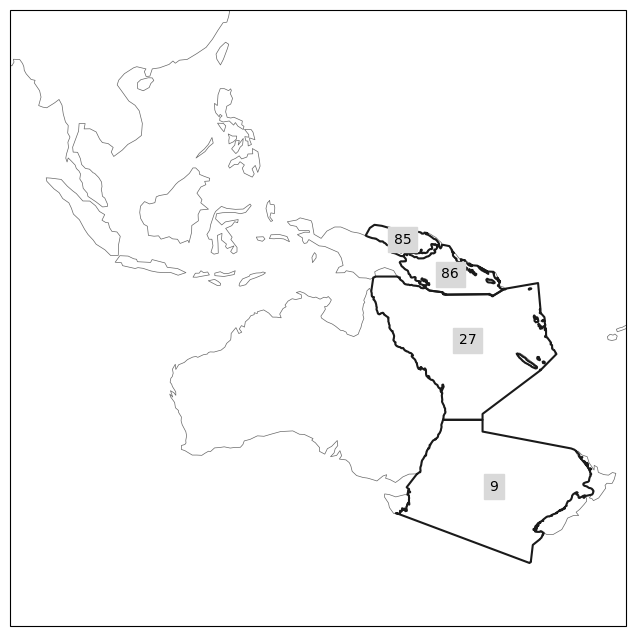

In [10]:
fig, ax = plt.subplots(figsize=(24, 8), subplot_kw={'projection': ccrs.PlateCarree()})
basins[basins_list].plot(add_label=True)
lon_min=90
lon_max=180
lat_min=-60
lat_max=30
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

In [11]:
mask = basins[basins_list].mask_3D(GIS_temp_ds.xt_ocean,GIS_temp_ds.yt_ocean)

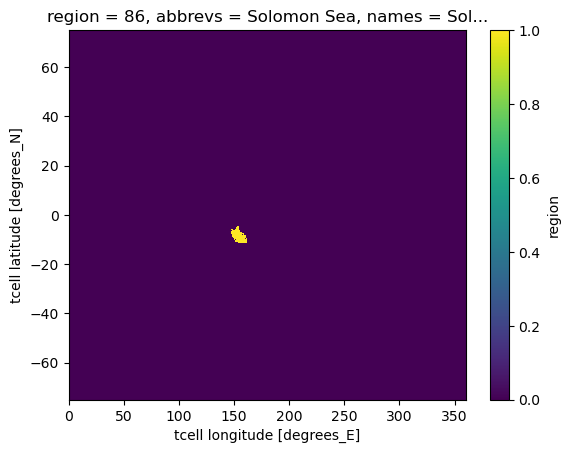

In [12]:
mask.isel(region=3).plot()

In [13]:
mask_3D = basins[basins_list].mask_3D(GIS_temp_ds.mean_temp_alltime)

In [14]:
region_Tasman = mask_3D.isel(region=(mask_3D.abbrevs == "Tasman Sea"))

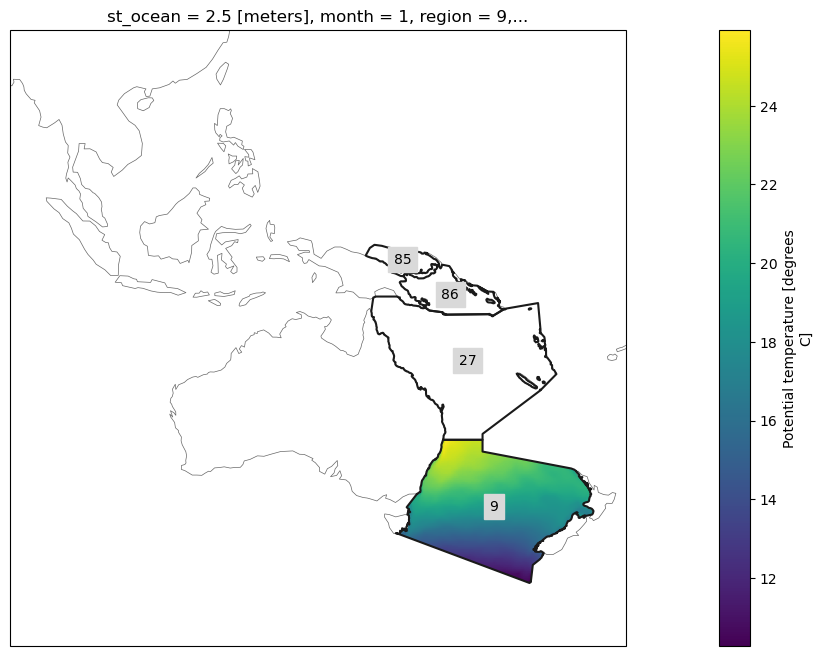

In [15]:
fig, ax = plt.subplots(figsize=(24, 8), subplot_kw={'projection': ccrs.PlateCarree()})
basins[basins_list].plot(add_label=True)
GIS_temp_ds.mean_temp_alltime.isel({'st_ocean':0,'month':0}).where(region_Tasman).plot()
lon_min=90
lon_max=180
lat_min=-60
lat_max=30
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# GSW

In [16]:
# Depth levels (assumed to be in meters)
depth = GIS_temp_ds['st_ocean']*-1
pressure = gsw.conversions.p_from_z(z=depth, lat=GIS_salt_ds['yt_ocean'], geo_strf_dyn_height=0, sea_surface_geopotential=0)

temperature = GIS_temp_ds['mean_temp_alltime']
salinity = GIS_salt_ds['mean_salt_alltime']

# Convert practical salinity (SP) to absolute salinity (SA) and in-situ temperature (t) to conservative temperature (CT)
SA = gsw.SA_from_SP(salinity, p=pressure, lon=GIS_salt_ds['xt_ocean'], lat=GIS_salt_ds['yt_ocean'])  # Assuming surface pressure and given lon, lat
CT = gsw.conversions.CT_from_t(SA, temperature,p=pressure)

# Compute density
density = gsw.density.rho(SA, CT, p=pressure)


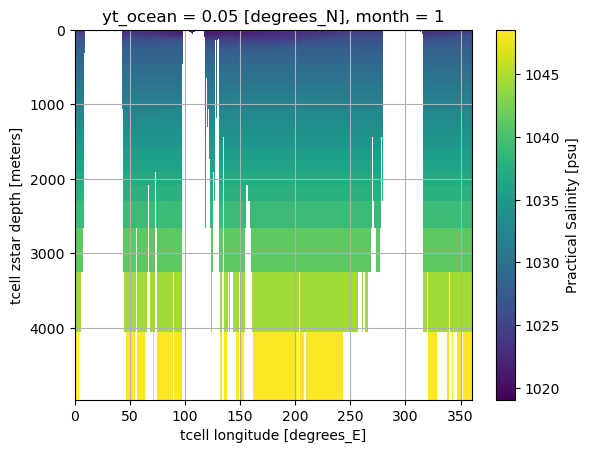

In [17]:
density.isel({'month':0}).sel({'yt_ocean':0},method='nearest').plot()
plt.gca().invert_yaxis()  # Invert the y-axis
plt.grid(True)
plt.show()

In [18]:
#weights = np.cos(np.deg2rad(GIS_temp_ds.yt_ocean))

regional_temp_stats = GIS_temp_ds.where(mask_3D)
regional_salt_stats = GIS_salt_ds.where(mask_3D)
regional_density = density.where(mask_3D)

In [25]:
regional_density

<xarray.DataArray 'mean_salt_alltime' (month: 12, st_ocean: 51, yt_ocean: 1500,
                                       xt_ocean: 3600, region: 4)> Size: 106GB
dask.array<where, shape=(12, 51, 1500, 3600, 4), dtype=float64, chunksize=(1, 11, 300, 720, 4), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 12kB -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
  * st_ocean  (st_ocean) float64 408B 2.5 7.5 12.5 ... 3.603e+03 4.509e+03
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * region    (region) int64 32B 9 27 85 86
    abbrevs   (region) <U12 192B 'Tasman Sea' 'Coral Sea' ... 'Solomon Sea'
    names     (region) <U12 192B 'Tasman Sea' 'Coral Sea' ... 'Solomon Sea'
Attributes:
    long_name:      Practical Salinity
    units:          psu
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity

In [26]:
%%time
datasets = []
for region in range(4):
    temperature_deci = regional_temp_stats['mean_temp_alltime'].isel({'region': region}).isel(st_ocean=slice(None, None, 2), xt_ocean=slice(None, None, 100), yt_ocean=slice(None, None, 100)).values
    salinity_deci = regional_salt_stats['mean_salt_alltime'].isel({'region': region}).isel(st_ocean=slice(None, None, 2), xt_ocean=slice(None, None, 100), yt_ocean=slice(None, None, 100)).values
    density_deci = regional_density.isel({'region': region}).isel(st_ocean=slice(None, None, 2), xt_ocean=slice(None, None, 100), yt_ocean=slice(None, None, 100)).values
    datasets.append((temperature_deci, salinity_deci, density_deci))

In [27]:
datasets

[(array([[[[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],
  
          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],
  
          [[nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           ...,
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan],
           [nan, nan, nan, ..., nan, nan, nan]],
  
          ...,
  
          [[nan, nan, nan, ..., nan, nan, nan],
          

In [19]:
%%time
#temperature = regional_temp_stats['mean_temp_alltime'].isel({'region':0}).values
#salinity = regional_salt_stats['mean_salt_alltime'].isel({'region':0}).values
#density = regional_density.isel({'region':0}).values

temperature = regional_temp_stats['mean_temp_alltime'].isel({'region':0}).isel(st_ocean=slice(None, None, 2), xt_ocean=slice(None, None, 100), yt_ocean=slice(None, None, 100)).values
salinity = regional_salt_stats['mean_salt_alltime'].isel({'region':0}).isel(st_ocean=slice(None, None, 2), xt_ocean=slice(None, None, 100), yt_ocean=slice(None, None, 100)).values
density = regional_density.isel({'region':0}).isel(st_ocean=slice(None, None, 2), xt_ocean=slice(None, None, 100), yt_ocean=slice(None, None, 100)).values


clean_temp = temperature[~np.isnan(temperature)]
clean_salt = salinity[~np.isnan(salinity)]
clean_density = density[~np.isnan(density)]

/g/data/es60/users/thomas_moore/miniconda3/envs/pangeo_bran2020_demo/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 21.24 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/es60/users/thomas_moore/miniconda3/envs/pangeo_bran2020_demo/lib/python3.10/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 22.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 47.9 s, sys: 3.5 s, total: 51.4 s
Wall time: 1min 2s


In [20]:
len(clean_salt)

876

In [21]:
len(clean_density)

876

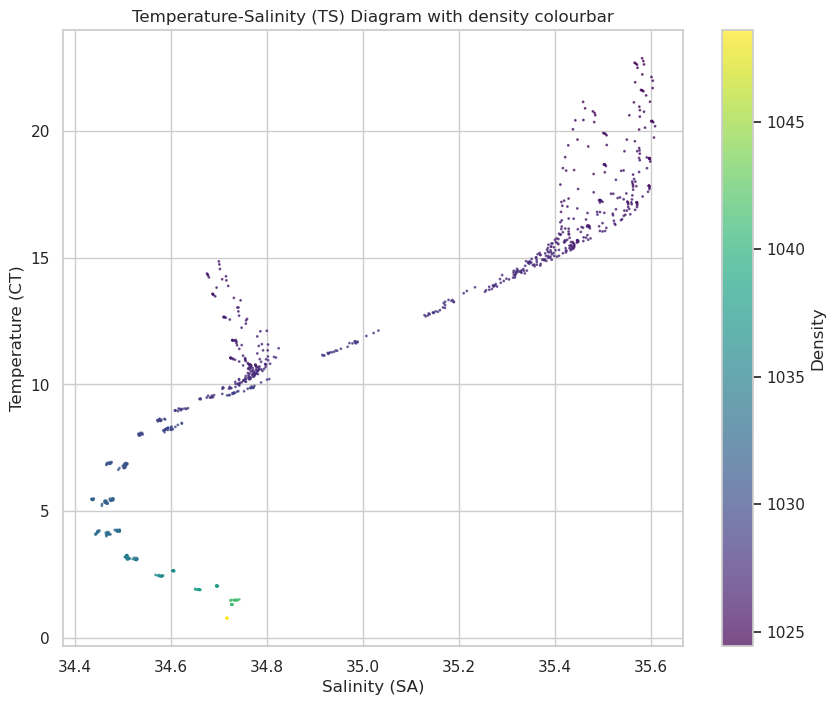

In [22]:
# Load your dataset
temperature = clean_temp
salinity = clean_salt
density = clean_density

# Create a grid for contour plot
#salinity_grid, temperature_grid = np.meshgrid(
#    np.linspace(salinity.min(), salinity.max(), 100),
#    np.linspace(temperature.min(), temperature.max(), 100)
#)

# Calculate density using a simplified equation of state (e.g., linear approximation)
#density = temperature_grid - 0.2 * salinity_grid

# Plotting the TS diagram with density contours
plt.figure(figsize=(10, 8))
sns.set(style='whitegrid')

# Scatter plot
plt.scatter(salinity, temperature, c=density, cmap='viridis', s=1, alpha=0.7)

# Contour plot
#contours = plt.contour(salinity_grid, temperature_grid, density, colors='black', alpha=0.5)
#plt.clabel(contours, inline=True, fontsize=8, fmt='%1.1f')

# Adding color bar
cbar = plt.colorbar()
cbar.set_label('Density')

# Adding labels and title
plt.xlabel('Salinity (SA)')
plt.ylabel('Temperature (CT)')
plt.title('Temperature-Salinity (TS) Diagram with density colourbar')

# Adding grid
plt.grid(True)

# Show plot
plt.show()

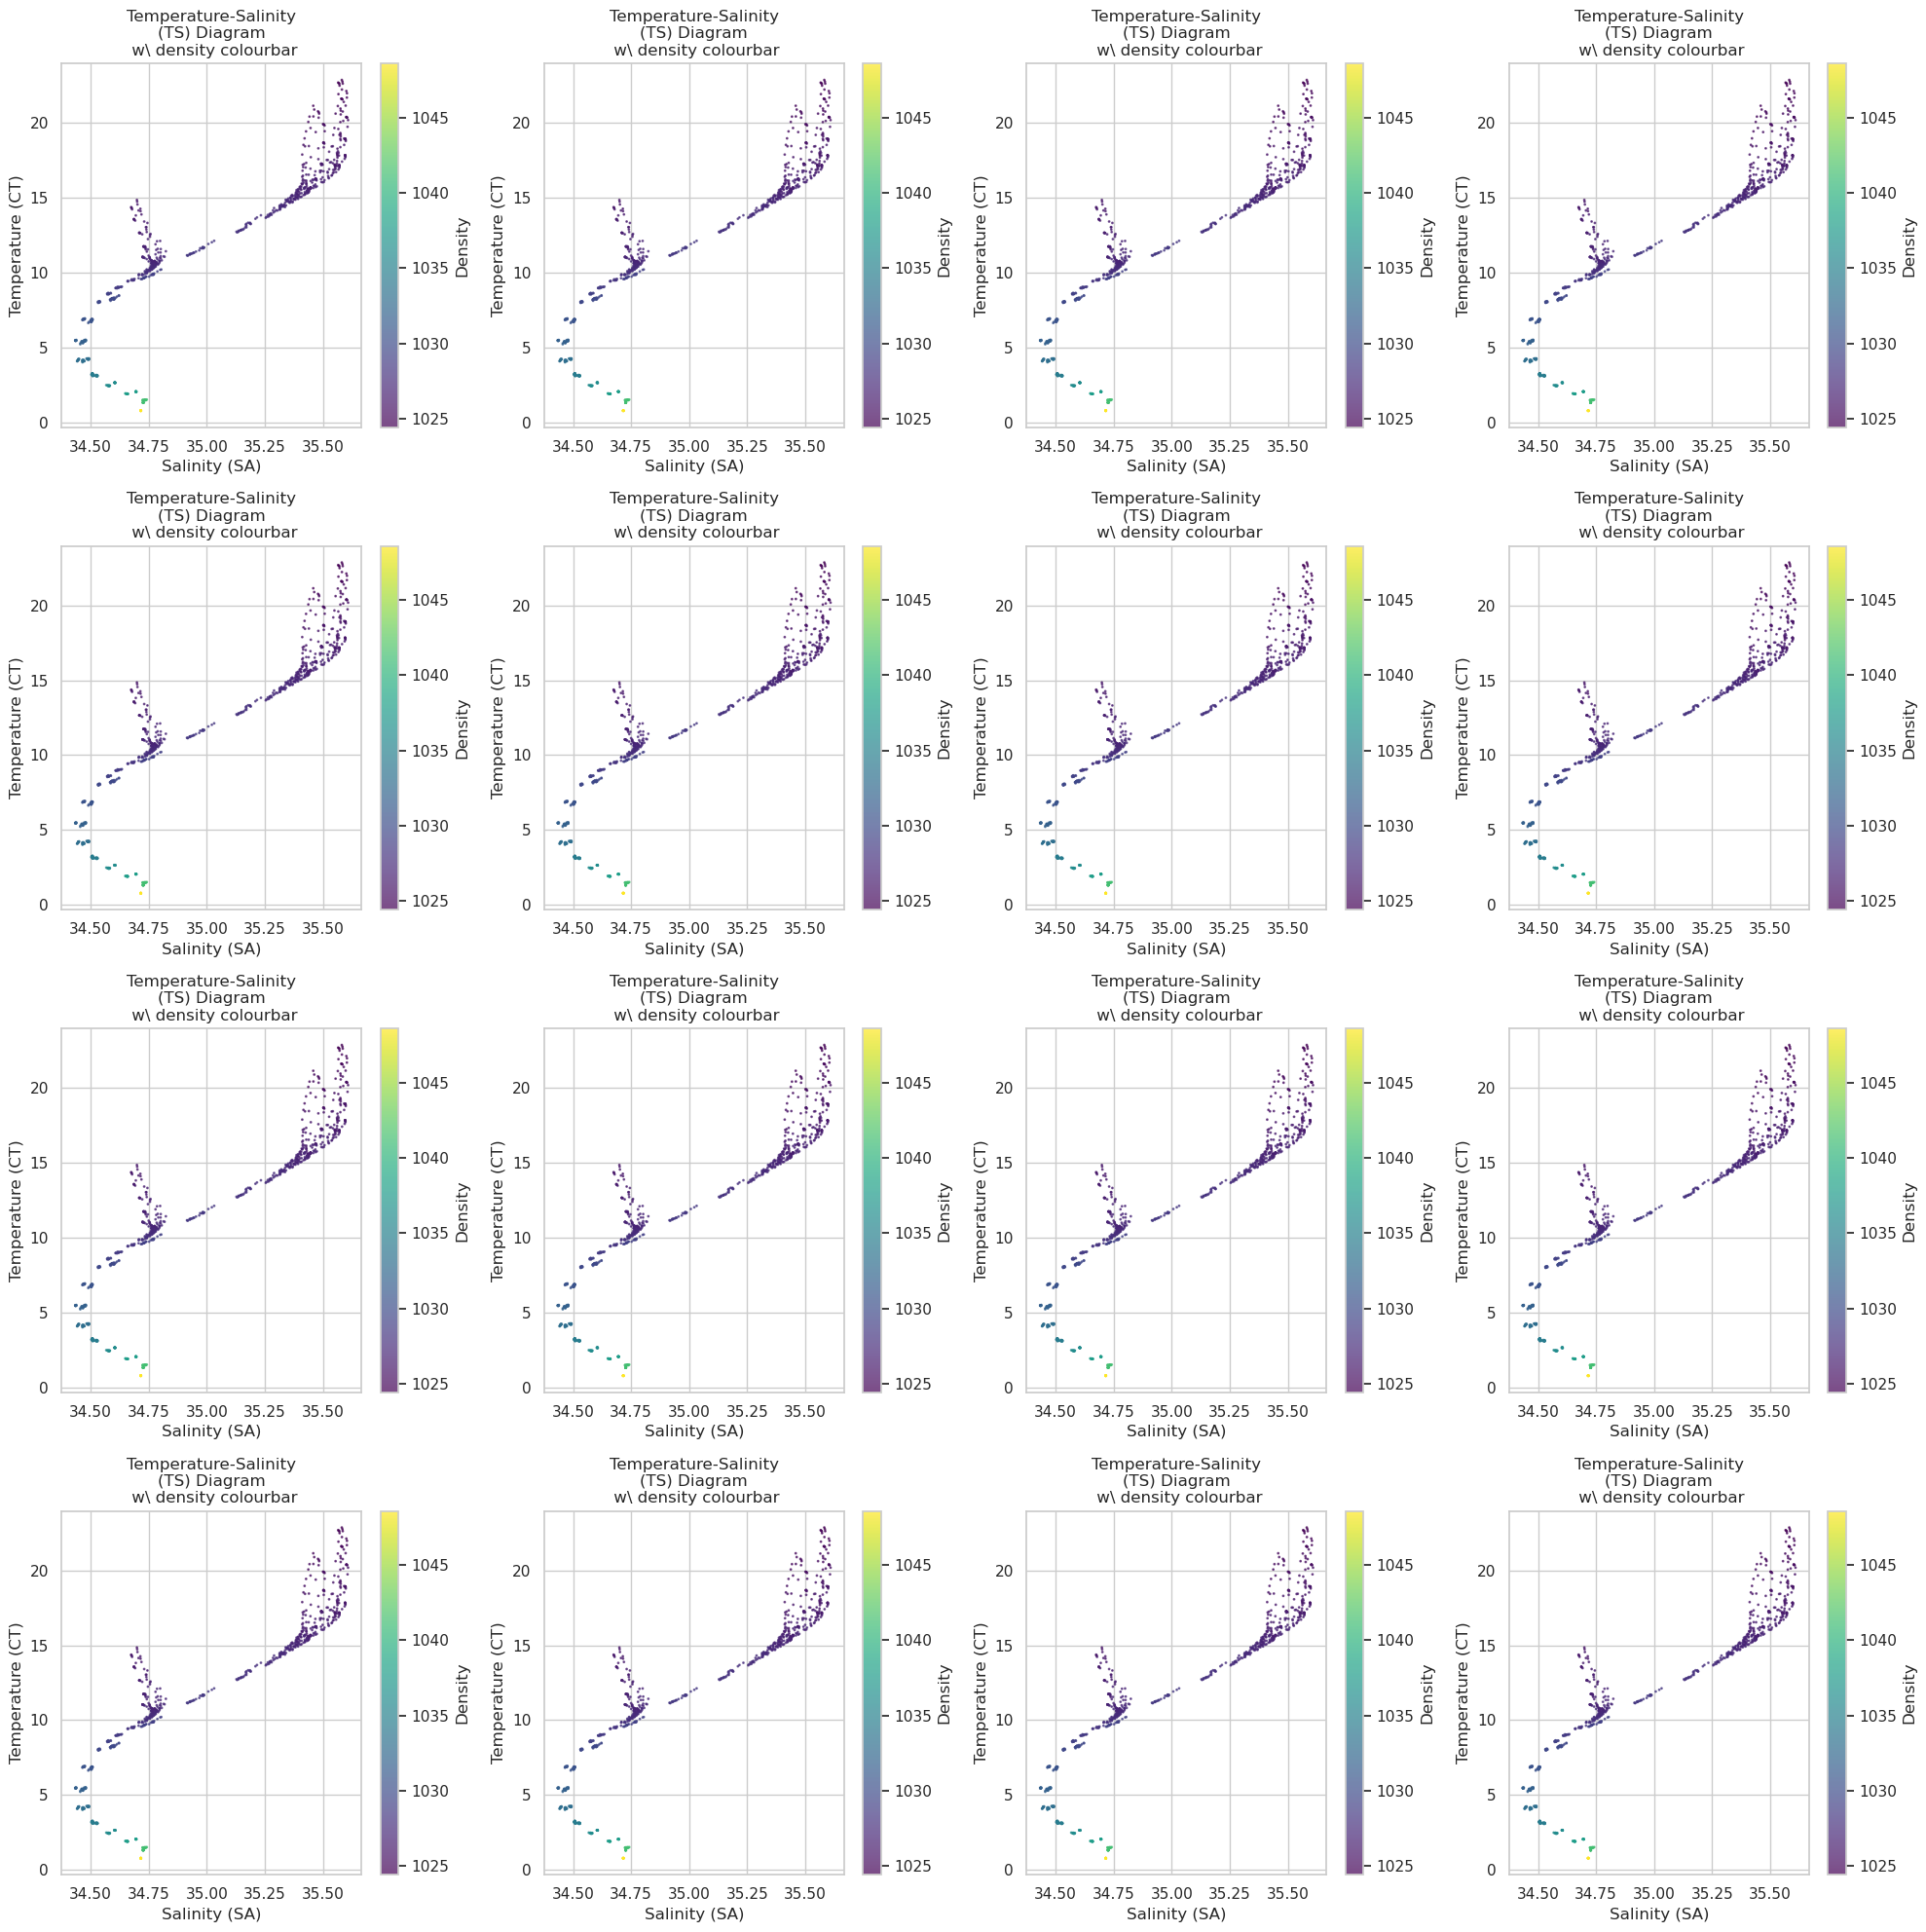

In [23]:
def plot_ts_diagram(ax, temperature, salinity, density):
    # Scatter plot
    sc = ax.scatter(salinity, temperature, c=density, cmap='viridis', s=1, alpha=0.7)

    # Adding color bar
    plt.colorbar(sc, ax=ax, label='Density')

    # Adding labels and title
    ax.set_xlabel('Salinity (SA)')
    ax.set_ylabel('Temperature (CT)')
    ax.set_title('Temperature-Salinity\n(TS) Diagram\n w\ density colourbar')

    # Adding grid
    ax.grid(True)

temperature_deci = temperature
salinity_deci = salinity
density_deci = density

# Create a list of datasets
datasets = [(temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci)
           ]  # replace with your datasets

# Create subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, (temperature, salinity, density) in enumerate(datasets):
    row = i // 4
    col = i % 4
    plot_ts_diagram(axs[row, col], temperature, salinity, density)

# Show plot
plt.tight_layout()
plt.show()

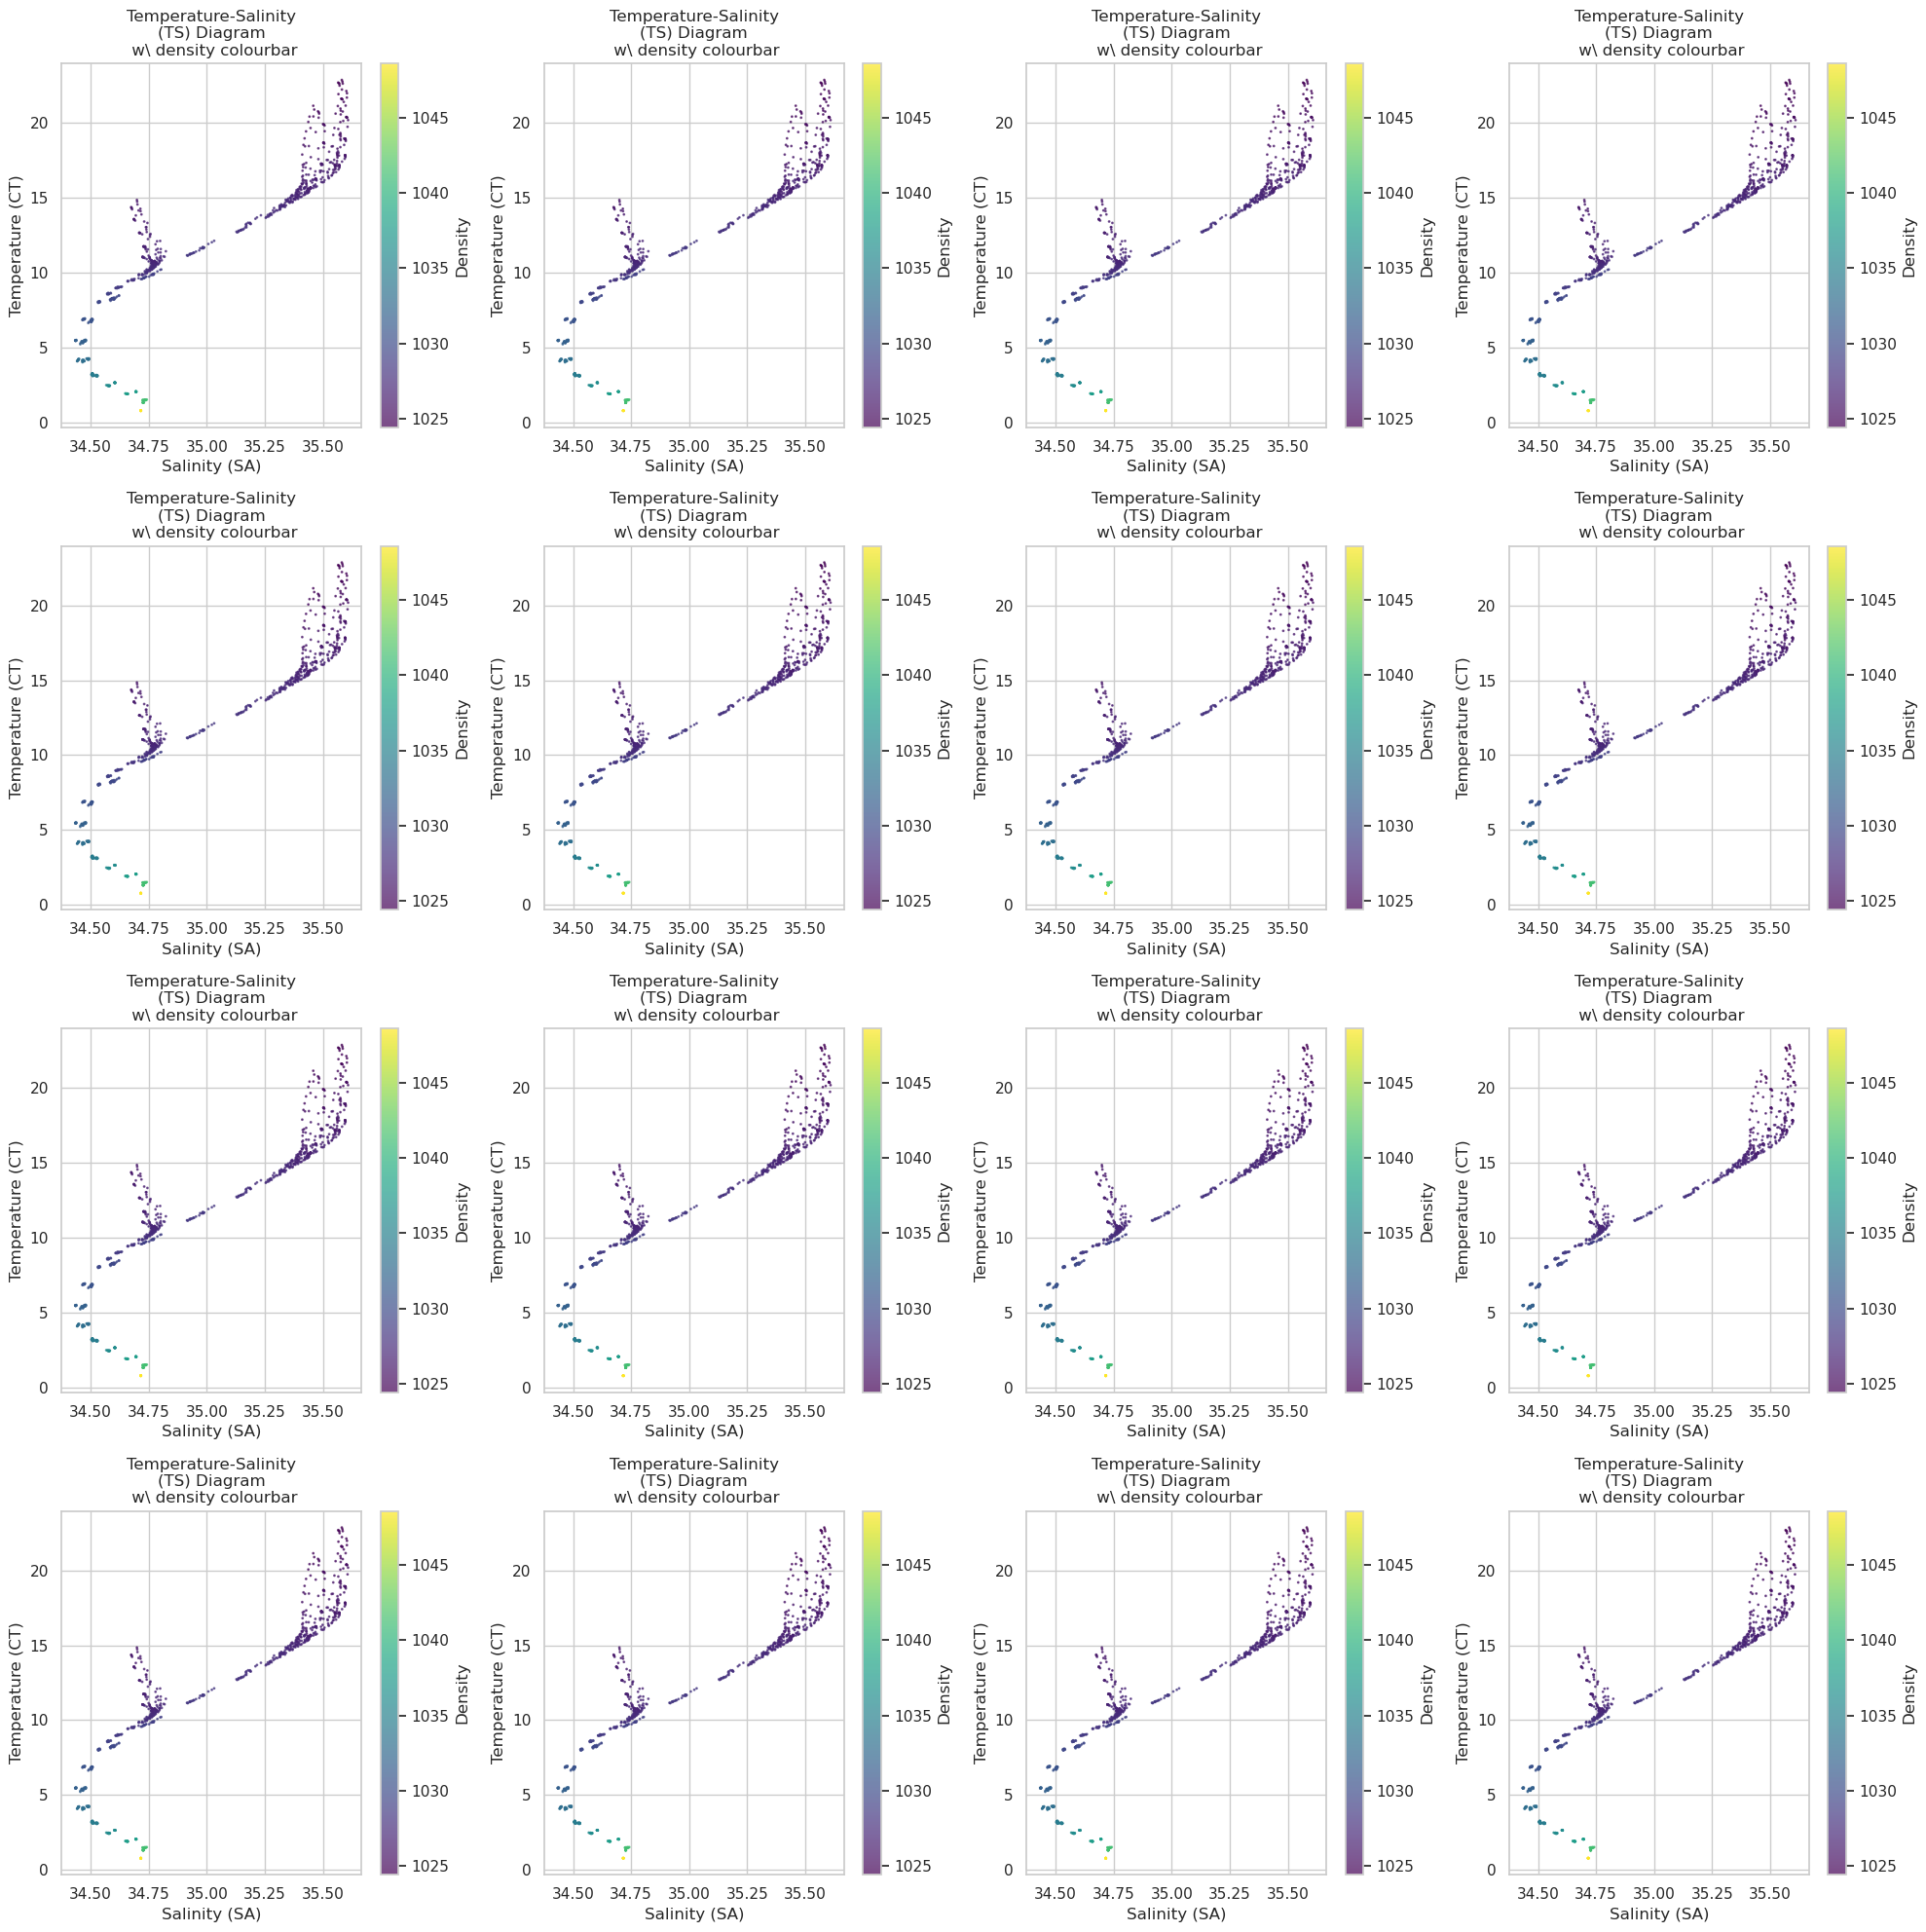

In [24]:
def plot_ts_diagram(ax, temperature, salinity, density):
    # Scatter plot
    sc = ax.scatter(salinity, temperature, c=density, cmap='viridis', s=1, alpha=0.7)

    # Adding color bar
    plt.colorbar(sc, ax=ax, label='Density')

    # Adding labels and title
    ax.set_xlabel('Salinity (SA)')
    ax.set_ylabel('Temperature (CT)')
    ax.set_title('Temperature-Salinity\n(TS) Diagram\n w\ density colourbar')

    # Adding grid
    ax.grid(True)

temperature_deci = temperature
salinity_deci = salinity
density_deci = density

# Create a list of datasets
datasets = [(temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci),
            (temperature_deci, salinity_deci, density_deci)
           ]  # replace with your datasets

# Create subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, (temperature, salinity, density) in enumerate(datasets):
    row = i // 4
    col = i % 4
    plot_ts_diagram(axs[row, col], temperature, salinity, density)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
regional_stats.isel({'month':6,'region':2}).mean_temp_el_nino.plot(y='st_ocean')
regional_stats.isel({'month':6,'region':2}).mean_temp_la_nina.plot(y='st_ocean')
regional_stats.isel({'month':6,'region':2}).mean_temp_neutral.plot(y='st_ocean')
# Set the y-axis limits
plt.ylim(0, 500)

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


In [ ]:
lat = GIS_temp_ds.yt_ocean.values
lon = GIS_temp_ds.xt_ocean.values

In [ ]:
mask_tasman_sea = basins[['Tasman Sea']].mask(lon, lat)
mask_coral_sea = basins[['Coral Sea']].mask(lon, lat)
mask_bismarck_sea = basins[['Bismarck Sea']].mask(lon, lat)
mask_solomon_sea = basins[['Solomon Sea']].mask(lon, lat)

# apply masks

In [ ]:
GIS_temp_ds.isel({'st_ocean':0,'month':0}).mean_temp_alltime.where(mask_tasman_sea).plot()

In [ ]:
def print_file_structure(root_path):
    for root, dirs, files in os.walk(root_path):
        level = root.replace(root_path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for file in files:
            print(f"{sub_indent}{file}")

print_file_structure(results_path)

In [ ]:
# Make path objects for each lowest level of the file structure
folder_paths = []
for root, dirs, files in os.walk(results_path):
    for folder in dirs:
        folder_path = os.path.join(root, folder)
        folder_paths.append(folder_path)
folder_paths

In [ ]:
temp_neutral = xr.open_mfdataset('/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/neutral/temp/*.nc',concat_dim='month',combine='nested',parallel=True)
temp_neutral

In [ ]:
temp_la_nina = xr.open_mfdataset('/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/la_nina/temp/*.nc',concat_dim='month',combine='nested',parallel=True)
temp_la_nina

In [ ]:
ds1 = temp_la_nina
ds2 = temp_neutral

In [ ]:
def load_GISready_ds(core_var='temp',phase='la_nina'):
    ds = xr.open_mfdataset('/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/'+phase+'/'+core_var+'/*.nc',concat_dim='month',combine='nested',parallel=True)
    return ds

In [ ]:
ds1 = load_GISready_ds(core_var='salt',phase='la_nina')
ds2 = load_GISready_ds(core_var='salt',phase='neutral')

In [ ]:
# Function to count NaNs in a dataset
def count_nans(ds):
    nan_counts = {}
    for var in ds.data_vars:
        nan_counts[var] = ds[var].isnull().sum().compute().item()  # Use .compute() to handle dask arrays
    return nan_counts

In [ ]:
# Count total NaNs in both datasets
total_nans_ds1 = count_nans(ds1)
total_nans_ds2 = count_nans(ds2)

# Print the total NaN counts for each dataset
print(f"Total NaNs in ds1: {total_nans_ds1}")
print(f"Total NaNs in ds2: {total_nans_ds2}")

In [ ]:
# Function to find variables matching the prefixes
def find_matching_vars(ds, prefixes):
    matching_vars = {}
    for prefix in prefixes:
        matching_vars[prefix] = [var for var in ds.data_vars if var.startswith(prefix)]
    return matching_vars

In [ ]:
core_var = 'eta_t'
phase1 = 'la_nina'
phase2 = 'neutral'

ds1 = load_GISready_ds(core_var=core_var,phase=phase1)
ds2 = load_GISready_ds(core_var=core_var,phase=phase2)


# Define a list of prefixes
prefixes = ['mean','min','max','std','quantile_05','median','quantile_95']

matching_vars_ds1 = find_matching_vars(ds1,prefixes)
matching_vars_ds2 = find_matching_vars(ds2,prefixes)


# Calculate number of subplots needed
num_prefixes = len(prefixes)
num_cols = 4
num_rows = (num_prefixes + num_cols - 1) // num_cols  # Ceiling division

# Create the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()



for i, prefix in enumerate(prefixes):

    diff = ds1[matching_vars_ds1[prefix]].rename({matching_vars_ds1[prefix][0]:prefix}) - ds2[matching_vars_ds2[prefix]].rename({matching_vars_ds2[prefix][0]:prefix})
    if 'st_ocean' in diff.variables:
        diff = diff.isel({'st_ocean': 0, 'month': 0})
    else:
        diff = diff.isel({'month': 0})

    # Plot the difference
    diff[prefix].plot(ax=axes[i], cmap='RdBu_r')
    axes[i].set_title(f'Difference btw {matching_vars_ds1[prefix][0]} \n and {matching_vars_ds2[prefix][0]} \n at surface')
    i += 1

# Remove any empty subplots
for j in range(i, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.suptitle(t = core_var+': phase '+ phase1 +' vs ' + phase2,fontsize=24, color='black')
plt.tight_layout()
plt.show()

## define phase and core variable names

In [ ]:
phase_list=['alltime','la_nina','el_nino','neutral']
core_var_list=['temp','salt','u','v','mld','eta_t']

## Define a dictionary to map variable names to colors and styles

In [ ]:
# Define a dictionary to map variable names to colors and styles
base_color_dict = {
    'mean': 'black',
    'min': 'navy',
    'max': 'red',
    'std': 'lightgrey',
    'median':'darkgrey',
    'quantile_05':'lightblue' ,
    'quantile_95': 'orange'
}
base_style_dict = {
    'alltime':'solid',
    'neutral':'dashdot',
    'la_nina':'dotted',
    'el_nino':'dashed'
}

In [ ]:
ds1 = load_GISready_ds(core_var='temp',phase='la_nina')
ds2 = load_GISready_ds(core_var='temp',phase='el_nino')
ds = xr.merge([ds1,ds2])

In [ ]:
color_dict={}
style_dict={}
variables = list(ds.data_vars)
for var_name in variables:
    # Get the first part of the variable name
    var_prefix = var_name.split('_')[0]
    
    # Check if the var_prefix exists in color_dict
    if var_prefix in base_color_dict:
        # Get the corresponding color from color_dict
        color_dict[var_name] = base_color_dict[var_prefix]
        
        # Use the color for further processing or visualization
        # . . .
        
    else:
        var_prefix = '_'.join(var_name.split('_')[:2])
        if var_prefix in base_color_dict:
            # Get the corresponding color from color_dict
            color_dict[var_name] = base_color_dict[var_prefix]
        
            # Use the color for further processing or visualization
            # ...
        else:
            print(f"No color defined for variable prefix: {var_prefix}")
for var_name in variables:
    # Get the first part of the variable name
    var_prefix = var_name.split('_')[-1]
    
    # Check if the var_prefix exists in color_dict
    if var_prefix in base_style_dict:
        # Get the corresponding color from color_dict
        style_dict[var_name] = base_style_dict[var_prefix]
        
        # Use the style for further processing or visualization
        # . . .
        
    else:
        var_prefix = '_'.join(var_name.split('_')[-2:])
        if var_prefix in base_style_dict:
            # Get the corresponding color from color_dict
            style_dict[var_name] = base_style_dict[var_prefix]
        
            # Use the style for further processing or visualization
            # ...
        else:
            print(f"No style defined for variable prefix: {var_prefix}")

In [ ]:
coordinate_names = {"lat_name_dict": {
        "temp": "yt_ocean",
        "salt": "yt_ocean",
        "u": "yu_ocean",
        "v": "yu_ocean",
        "mld": "yt_ocean",
        "eta_t": "yt_ocean"
    },
    "lon_name_dict": {
        "temp": "xt_ocean",
        "salt": "xt_ocean",
        "u": "xu_ocean",
        "v": "xu_ocean",
        "mld": "xt_ocean",
        "eta_t": "xt_ocean"
    }
                   }

# equator @ surface

In [ ]:
sel_dict = {'st_ocean': 0, 'yt_ocean': 0,'month':1}

In [ ]:
depth_sel_dict = {'st_ocean':0}
lon_sel_dict = {coordinate_names["lat_name_dict"][core_var]:0}
month_sel_dict = {'month':3}
sel_dict = {**depth_sel_dict, **lon_sel_dict, **month_sel_dict}

In [ ]:
eq = ds.sel(sel_dict,method='nearest').compute()

In [ ]:
from brokenaxes import brokenaxes
#plot
# Get the list of variables in the dataset
variables = list(ds.data_vars)

# Plot line for each variable
fig = plt.figure(figsize=(20, 10))  # Set the figure size here
bax = brokenaxes(ylims=((0, 5), (18, 32)), hspace=.05)
for variable in variables:
    color = color_dict.get(variable, 'black')  # Use 'black' as default color if variable is not in the dictionary
    style = style_dict.get(variable, 'solid')
    #bax.plot(ds[variable].sel(sel_dict,method='nearest'),color=color, linestyle=style)
    bax.plot(eq[coordinate_names["lon_name_dict"][core_var]].values,eq[variable].values,color=color, linestyle=style, label=variable)
    # Add text to a specific location

y_location = 0.1    
bax.big_ax.text((25/360), y_location, 'AFRICA', fontsize=12, color='brown', rotation=90)
bax.big_ax.text((105/360), y_location, 'INDONESIA', fontsize=12, color='brown', rotation=90)
bax.big_ax.text((290/360), y_location, 'SOUTH AMERICA', fontsize=12, color='brown', rotation=90)
# Add title
plt.title('Statistics at Equator in month '+str(month_sel_dict['month'])+'\nBRAN2020 reanalysis at surface')
#legend
# Add legend with two columns
bax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.show()


In [ ]:
ds2[matching_vars_ds2[prefix]]

In [ ]:
def build_nc_path_list(root_directory = "/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/",search_string = "_temp_"):
    file_paths = []
    for root, dirs, files in os.walk(root_directory):
        for file in files:
            if file.endswith(".nc") and search_string in file:
                    file_paths.append(os.path.join(root, file))
    file_paths.sort()
    return file_paths

In [ ]:
def build_nc_path_list(root_directory="/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/", search_string="_temp_", search_string2="neutral"):
    file_paths = []
    for root, dirs, files in os.walk(root_directory):
        if search_string2 in dirs:
            for file in files:
                if file.endswith(".nc") and search_string in file:
                    file_paths.append(os.path.join(root, file))
        file_paths.sort()
    return file_paths

In [ ]:
file_paths = build_nc_path_list(root_directory="/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_GISready_results/", search_string="_temp_", search_string2="neutral")
file_paths

In [ ]:
temp = xr.open_mfdataset(build_nc_path_list(),parallel=True,concat_dim='month', combine='nested').groupby('month').first()
salt = xr.open_mfdataset(build_nc_path_list(search_string = "_salt_"),parallel=True,concat_dim='month', combine='nested').groupby('month').first()
u = xr.open_mfdataset(build_nc_path_list(search_string = "_u_"),parallel=True,concat_dim='month', combine='nested').groupby('month').first()
v = xr.open_mfdataset(build_nc_path_list(search_string = "_v_"),parallel=True,concat_dim='month', combine='nested').groupby('month').first()
mld = xr.open_mfdataset(build_nc_path_list(search_string = "_mld_"),parallel=True,concat_dim='month', combine='nested').groupby('month').first()
eta_t = xr.open_mfdataset(build_nc_path_list(search_string = "_eta_t_"),parallel=True,concat_dim='month', combine='nested').groupby('month').first()

In [ ]:
check_path = '/g/data/es60/users/thomas_moore/clim_demo_results/daily/bran2020_final_results/'

In [ ]:
temp2 = xr.open_mfdataset(check_path+'*temp*.nc',chunks={})

In [ ]:
temp2 - temp

In [ ]:
# Calculate the difference for each variable
ds_diff = temp2 - temp

# Plotting
variables = ds_diff.data_vars.keys()
num_vars = len(variables)

# Create subplots
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(20, 30))  # Adjust the layout as needed
axes = axes.flatten()

for i, var in enumerate(variables):
    ax = axes[i]
    ds_diff[var].isel(month=0, st_ocean=0).plot(ax=ax)  # Adjust the slicing as needed
    ax.set_title(var)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
temp = xr.open_mfdataset(folder_paths[8]+'/*.nc',parallel=True,concat_dim='month', combine='nested')

In [ ]:
temp.mean_temp_el_nino.isel(st_ocean=0).sel(yt_ocean = -20,method='nearest').mean('xt_ocean').plot()

## coordinate nomeclature

In [ ]:
coordinate_names = {
    "lat_name_dict": {
        "temp": "yt_ocean",
        "salt": "yt_ocean",
        "u": "yu_ocean",
        "v": "yu_ocean",
        "mld": "yt_ocean",
        "eta_t": "yt_ocean"
    },
    "lon_name_dict": {
        "temp": "xt_ocean",
        "salt": "xt_ocean",
        "u": "xu_ocean",
        "v": "xu_ocean",
        "mld": "xt_ocean",
        "eta_t": "xt_ocean"
    },
    "depth_name_dict": {
        "temp": "st_ocean",
        "salt": "st_ocean",
        "u": "st_ocean",
        "v": "st_ocean"
    }
}

# $The$ $End$

In [ ]:
client.shutdown()